### Intro
This is a practice notebook for Rita. 
Since no GPU, training on Colab: https://colab.research.google.com/drive/1Lp5xPuN4hG4n2LNZp44G9CBzC-fqYC7Q?usp=sharing 

In [1]:
import os
from os import listdir
import numpy as np
import nibabel as nib #for reading .nii.gz format MRI files
import matplotlib.pyplot as plt
import pandas as pd

import pickle

import monai
from monai.data import CacheDataset, DataLoader, CSVDataset
from monai.transforms import (
    EnsureChannelFirstd, EnsureChannelFirst,
    Activations,
    AsDiscreted, AsDiscrete,
    Compose,
    LoadImaged, LoadImage,
    SplitDimd, SplitDim,
    Orientationd,
    Randomizable,
    Resized, Resize,
    CenterSpatialCropd, CenterSpatialCrop,
    ScaleIntensityd,
    Spacingd,
    EnsureTyped,
    ToTensord,ToTensor,
    NormalizeIntensityd, NormalizeIntensity,
)

from tqdm.auto import tqdm
#import cv2 #opencv

/Users/rita/anaconda3/envs/hfenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import timm
import torch
import torch.nn as nn
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

### Take a look at models

In [4]:
import huggingface_hub

In [8]:
# default model with classifier
m0 = timm.create_model("mobilevit_xxs.cvnets_in1k", pretrained=True)
print(m0)

RuntimeError: Hugging Face hub model specified but package not installed. Run `pip install huggingface_hub`.

In [9]:
import sys; 
#print(sys.executable) #/Users/rita/anaconda3/envs/hfenv/bin/python
print(sys.path) 
#sys.path.append('/Users/rita/anaconda3/envs/hfenv/lib/python3.12/site-packages/huggingface_hub')

['/Users/rita/anaconda3/envs/hfenv/lib/python312.zip', '/Users/rita/anaconda3/envs/hfenv/lib/python3.12', '/Users/rita/anaconda3/envs/hfenv/lib/python3.12/lib-dynload', '', '/Users/rita/anaconda3/envs/hfenv/lib/python3.12/site-packages', '/Users/rita/anaconda3/envs/hfenv/lib/python3.12/site-packages/huggingface_hub']


In [12]:
m0 = timm.create_model("mobilevitv2_050", features_only=True)
#print(m0.feature_info.get_dicts())
#mobilevit_xxs
#[{'num_chs': 16, 'reduction': 2, 'module': 'stages.0', 'stage': 1, 'index': 0}, 
# {'num_chs': 24, 'reduction': 4, 'module': 'stages.1', 'stage': 2, 'index': 1}, 
# {'num_chs': 48, 'reduction': 8, 'module': 'stages.2', 'stage': 3, 'index': 2}, 
# {'num_chs': 64, 'reduction': 16, 'module': 'stages.3', 'stage': 4, 'index': 3}, 
# {'num_chs': 320, 'reduction': 32, 'module': 'final_conv', 'stage': 5, 'index': 4}]

#mobilevitv2_050
#[{'num_chs': 32, 'reduction': 2, 'module': 'stages.0', 'stage': 1, 'index': 0}, 
# {'num_chs': 64, 'reduction': 4, 'module': 'stages.1', 'stage': 2, 'index': 1}, 
# {'num_chs': 128, 'reduction': 8, 'module': 'stages.2', 'stage': 3, 'index': 2}, 
# {'num_chs': 192, 'reduction': 16, 'module': 'stages.3', 'stage': 4, 'index': 3}, 
# {'num_chs': 256, 'reduction': 32, 'module': 'final_conv', 'stage': 5, 'index': 4}]

[{'num_chs': 32, 'reduction': 2, 'module': 'stages.0', 'stage': 1, 'index': 0}, {'num_chs': 64, 'reduction': 4, 'module': 'stages.1', 'stage': 2, 'index': 1}, {'num_chs': 128, 'reduction': 8, 'module': 'stages.2', 'stage': 3, 'index': 2}, {'num_chs': 192, 'reduction': 16, 'module': 'stages.3', 'stage': 4, 'index': 3}, {'num_chs': 256, 'reduction': 32, 'module': 'final_conv', 'stage': 5, 'index': 4}]


In [16]:
# Loop through the model's layers and print their weights
i = 0
for name, param in m0.named_parameters():
    #print(f"Layer: {name} | Shape: {param.shape} ") #| Values: {param[:2]}")  # printing only first 2 values for brevity
    i+=1
print(i)

192


In [ ]:
# We want Penultimate Layer Features (Pre-Classifier Features), not classification
# this one ends with:
#   (fc): Identity()
#   (flatten): Identity()
m1 = timm.create_model(
    "mobilevit_xxs.cvnets_in1k", 
    pretrained=True, 
    num_classes=0, 
    global_pool='')


# pretrained weights need <batch B, 3 channels, H, W>:
# ex. (1, 3, 224, 224) -> torch.Size([1,1000]) if classifier
# ex.                  -> torch.Size([1, 320, 7, 7]) if preclassifier (no classifier head & pooling)
# ex. (1, 3, 96, 96)   -> torch.Size([1, 320, 3, 3]) if classifier
x = torch.randn(1, 3, 96, 96) 
o = m1(x)  
#print(m1)

In [ ]:
# MobileViTv2
# This one with LinearTransformerBlock(...), LinearSelfAttention(...) classes 
#   crop_pct=0.888?
m2 = timm.create_model(
    "mobilevitv2_050.cvnets_in1k", 
    pretrained=True, 
    num_classes=0, 
    global_pool='')

# pretrained weights need <batch B, 3 channels, H, W>:
# ex. (1, 3, 224, 224) -> torch.Size([1,1000]) if classifier
# ex.                  -> torch.Size([1, 256, 8, 8]) if preclassifier (no classifier head & pooling)
# ex. (1, 3, 96, 96)   -> torch.Size([1, 256, 4, 4]) if classifier
x = torch.randn(1, 3, 224, 224) 
o = m2(x)
print(o.shape)  
print(m2)

### Load Images from csv

In [ ]:
os.chdir("/Users/rita/Desktop/harini_lab/")
cwd = os.getcwd() #/Users/rita/Desktop/
print(cwd)

In [ ]:
file_dir = 'PROSTATEx/Files/lesions/'
csvFile_image = pd.read_csv(os.path.join(file_dir,'image_list.csv')) #(201,2)
csvFile_score = pd.read_csv(os.path.join(file_dir,'prostatex_classes.csv')) #(299,3)

img_dir_ADC = os.path.join(file_dir, 'Images/ADC') #PROSTATEx/Files/lesions/Images/ADC/X.nii.gz
label_dir_ADC = os.path.join(file_dir, 'Masks/ADC') #PROSTATEx/Files/lesions/Masks/ADC/X.nii.gz

img_dir_T2 = os.path.join(file_dir, 'Images/T2') #PROSTATEx/Files/lesions/Images/T2/X.nii.gz
label_dir_T2 = os.path.join(file_dir, 'Masks/T2') #PROSTATEx/Files/lesions/Masks/ADC/X.nii.gz



In [ ]:
print(csvFile_score["T2"])

In [ ]:
#for i in listdir(label_dir_ADC):
    # ex. ProstateX-0006-Finding1-ep2d_diff_tra_DYNDIST_ADC_ROI.nii.gz
 #   chID = i[0:23]
#    print(chID)

In [ ]:
#csvFile_score["ID"] = csvFile_score["ID"].str.replace('_', '-', n=1)
csvFile_score["ADC"] = label_dir_ADC + '/' + csvFile_score["ADC"]
csvFile_score["T2"] = label_dir_T2 + '/' + csvFile_score["T2"]
print(csvFile_score)

In [ ]:
# loop to create dataset (IP)
X_train_ADC = [] #len = 201
X_train_T2 = []

#how to deal with clinical significant & Gleason score?
#could have multiple lesions mask for one patient?
#   check how standard dataset organized them?
y_mask_ADC = []
y_mask_T2 = []

for i in range(len(csvFile_image)): 
    img_filename_ADC, img_filename_T2 = csvFile_image.iloc[i]
    img_complete_path_ADC = os.path.join(img_dir_ADC, img_filename_ADC) + '.nii.gz'
    img_ADC = nib.load(img_complete_path_ADC)
    imgdata_ADC = img_ADC.get_fdata() #(84, 128, 19)

    img_complete_path_T2 = os.path.join(img_dir_T2, img_filename_T2) + '.nii.gz'
    img_T2 = nib.load(img_complete_path_T2)
    imgdata_T2 = img_T2.get_fdata() #(384, 384, 19)

    # 2D network
    # or should I just use the middle 3 slices (mask at 13~17) for each?
    num_slice = imgdata_ADC.shape[2]
    for i in range(0, num_slice-3, 3): #0~16, step=3: 0,3,6,9,12,15
        slice_ADC = imgdata_ADC[:,:,i:i+3]
        X_train_ADC.append(slice_ADC)

        slice_T2 = imgdata_T2[:,:,i:i+3]
        X_train_T2.append(slice_T2)
    #below is the filename I changed to match csv 
    #all csv items are added .nii.gz at the end for better MONAI reading
    # ADC:
    #ProstateX-0025_ep2d_diff_tra_7a.nii.gz ->7
    #ProstateX-0113_ep2d_diff_tra_9.nii.gz -> 10
    #ProstateX-0203_diffusie-3ProstateX-0203_diffusie-3Scan-4bval_fs_7.niiScan-4bval_fs_7.nii
    #-> ProstateX-0203_diffusie-3Scan-4bval_fs_7.nii.gz
    # T2:
    #ProstateX-0128_t2_tse_tra_5.nii -> _5.nii.gz: nib.load(), nib.save()
    # Missing:
    # 0052, 0080, 0138, 
    
    

In [ ]:
X_train_T2[5].shape #201*6=1217???

In [ ]:
#csvFile_image['ADC'] = csvFile_image['ADC'] + '.nii.gz'
#csvFile_image['T2'] = csvFile_image['T2'] + '.nii.gz'
csvFile_image['ADC'] = img_dir_ADC + '/' + csvFile_image['ADC'] 
csvFile_image['T2'] = img_dir_T2 + '/' + csvFile_image['T2']


print(csvFile_image)

In [ ]:
output_file = 'PROSTATEx_Classes.csv'
csvFile_score.to_csv(output_file, index=False)


In [ ]:
fig = plt.figure()
fig.add_subplot(2, 2, 1); plt.imshow(X_train_ADC[7][:,:,1].T, cmap='Greys_r'); plt.title("Example ADC Image")
fig.add_subplot(2, 2, 2); plt.imshow(X_train_T2[7][:,:,1].T, cmap='Greys_r'); plt.title("Example T2 Image")
print(X_train_T2[7].shape) 


In [ ]:
# save dataset
train_pkl_ADC = open('train_multi_ADC.pkl','wb')
pickle.dump(X_train_ADC, train_pkl_ADC, protocol=pickle.HIGHEST_PROTOCOL)
train_pkl_ADC.close()
train_pkl_T2 = open('train_multi_T2.pkl','wb')
pickle.dump(X_train_T2, train_pkl_T2, protocol=pickle.HIGHEST_PROTOCOL)
train_pkl_T2.close()

In [ ]:
# example images
img_filename_ADC, img_filename_T2 = csvFile_image.iloc[10] #change for different imgs

img_complete_path_ADC = os.path.join(img_dir_ADC, img_filename_ADC) + '.nii.gz'
img_ADC = nib.load(img_complete_path_ADC)
imgdata_ADC = img_ADC.get_fdata() #(84, 128, 19)

slice_ADC = imgdata_ADC[:,:,13:16] #(mask at 13~17) #(84,128)
plt.imshow(slice_ADC[:,:,2].T, cmap='Greys_r'); plt.title("Example ADC Image")

img_complete_path_T2 = os.path.join(img_dir_T2, img_filename_T2) + '.nii.gz'
img_T2 = nib.load(img_complete_path_T2)
imgdata_T2 = img_T2.get_fdata() #(384, 384, 19)

slice_T2 = imgdata_T2[:,:,13:16] #changed
#plt.imshow(slice_T2[:,:,2].T, cmap='Greys_r'); plt.title("Example T2 Image")
print(slice_ADC.shape) 

In [ ]:
# save
np.save('ex_multi_slice_ADC', slice_ADC)

In [ ]:
csvFile_label['chID'] = csvFile_label['ID'].str[0:14]
csvFile_image['chID'] = csvFile_image_ori['ADC'].str[0:14] #201

print(csvFile_image)
test = pd.merge(csvFile_image, csvFile_label, on='chID')
output_file = 'lesions_total.csv'
test.to_csv(output_file, index=False)

In [ ]:
test = pd.merge(csvFile_image, csvFile_label, on='chID')
output_file = 'lesions_total.csv'
test.to_csv(output_file, index=False)

### Playground

#### Use pkl

In [ ]:
#load example image
slice_ADC = np.load('ex_multi_slice_ADC.npy')[:,:,1]
slice_T2 = np.load('ex_multi_slice_T2.npy')[:,:,1]


fig = plt.figure()
#fig.add_subplot(2, 2, 1); plt.imshow(slice_T2[:,:,1].T, cmap='Greys_r'); plt.title("Example T2 Image")
fig.add_subplot(2, 2, 1); plt.imshow(slice_T2.T, cmap='Greys_r'); plt.title("Example T2 Image")
print(slice_T2.shape) 
#fig.add_subplot(2, 2, 2); plt.imshow(slice_ADC[:,:,1].T, cmap='Greys_r'); plt.title("Example ADC Image")
fig.add_subplot(2, 2, 2); plt.imshow(slice_ADC.T, cmap='Greys_r'); plt.title("Example ADC Image")


In [5]:
os.chdir("/Users/rita/Desktop/harini_lab/")
cwd = os.getcwd() #/Users/rita/Desktop/
print(cwd)

/Users/rita/Desktop/harini_lab


In [ ]:
# load data
f = open('PROSTATEx/train_multi_ADC.pkl', 'rb')
X_ADC = pickle.load(f)
f.close()
f = open('PROSTATEx/train_multi_T2.pkl', 'rb')
X_T2 = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure()
fig.add_subplot(2, 2, 1); plt.imshow(X_ADC[7][:,:,1].T, cmap='Greys_r'); plt.title("Example ADC Image")
fig.add_subplot(2, 2, 2); plt.imshow(X_T2[7][:,:,1].T, cmap='Greys_r'); plt.title("Example T2 Image")
print(X_T2[7].shape) 

In [ ]:
slice_ADC = X_ADC[7]

#### Use MONAI

In [5]:
#copy from above
os.chdir("/Users/rita/Desktop/harini_lab/")
cwd = os.getcwd() #/Users/rita/Desktop/
print(cwd)

file_dir = 'PROSTATEx/Files/lesions/'
#csvFilePath_image = os.path.join(file_dir,'image_list.csv')
#csvFilePath_label = os.path.join(file_dir,'prostatex_classes.csv')
csvFilePath_total = os.path.join(file_dir,'lesions_total.csv')

#csvFile_image = pd.read_csv(csvFilePath_image)
#csvFile_label = pd.read_csv(csvFilePath_label)
csvFile_total = pd.read_csv(csvFilePath_total) #(299,8)

img_dir_ADC = os.path.join(file_dir, 'Images/ADC') #lesions/Images/ADC/X.nii.gz
img_dir_T2 = os.path.join(file_dir, 'Images/T2') #lesions/Images/T2/X.nii.gz
label_dir_ADC = os.path.join(file_dir, 'Masks/ADC') #PROSTATEx/Files/lesions/Masks/ADC/X.nii.gz
label_dir_T2 = os.path.join(file_dir, 'Masks/T2') #PROSTATEx/Files/lesions/Masks/T2/X.nii.gz



/Users/rita/Desktop/harini_lab


In [6]:
# load by MONAI

# create transform in MONAI format
# can also use transform from timm???
''' 
Compose(
    Resize(size=288, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(256, 256))
    ToTensor()
    Normalize(mean=tensor([0., 0., 0.]), std=tensor([1., 1., 1.]))
)
'''
train_transforms = Compose(
    [
        LoadImaged(keys=["ADC_image", "ADC_mask"],channel_dim=2), #default NibelReader #[84, 128, 19]
        EnsureChannelFirstd(keys=["ADC_image", "ADC_mask"]), #[19, 84, 128]
        #SplitDimd(keys=["ADC_image", "ADC_mask"], dim = 0), #leave out the splitting??
        Resized(keys=["ADC_image", "ADC_mask"], spatial_size=(288,288), anti_aliasing=True), #[1, 288, 288]
        CenterSpatialCropd(keys=["ADC_image", "ADC_mask"], roi_size=(256,256)), #[1, 256, 256]
        #ScaleIntensityd(keys="image"),
        #EnsureTyped(keys="image"),
        ToTensord(keys=["ADC_image", "ADC_mask"]),
        NormalizeIntensityd(keys=["ADC_image"]),
        
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["ADC_image", "ADC_mask"],channel_dim=2), #default NibelReader #[84, 128, 19]
        EnsureChannelFirstd(keys=["ADC_image", "ADC_mask"]), #[1, 84, 128, 19]
        Resized(keys=["ADC_image", "ADC_mask"], spatial_size=(288,288), anti_aliasing=True), #mode='bicubic'??
        CenterSpatialCropd(keys=["ADC_image", "ADC_mask"], roi_size=(256,256)),
        ToTensord(keys=["ADC_image", "ADC_mask"]),
        NormalizeIntensityd(keys=["ADC_image"]),
        
    ]
)

In [7]:
total_dataset = CSVDataset(
    src=csvFilePath_total,
    transform=train_transforms,
)
print(pd.DataFrame(total_dataset.data))
# ADC_image: ProstateX-0000_ep2d_diff_tra_7.nii.gz   ADC_mask: 


               chID                       ID  Clinically Significant  \
0    ProstateX-0000  ProstateX-0000-Finding1                    True   
1    ProstateX-0001  ProstateX-0001-Finding1                   False   
2    ProstateX-0002  ProstateX-0002-Finding1                    True   
3    ProstateX-0002  ProstateX-0002-Finding2                   False   
4    ProstateX-0003  ProstateX-0003-Finding1                   False   
..              ...                      ...                     ...   
294  ProstateX-0201  ProstateX-0201-Finding1                    True   
295  ProstateX-0202  ProstateX-0202-Finding1                    True   
296  ProstateX-0202  ProstateX-0202-Finding2                   False   
297  ProstateX-0203  ProstateX-0203-Finding1                    True   
298  ProstateX-0203  ProstateX-0203-Finding2                    True   

       Gleason Grade Group                                          ADC_image  \
0                        3  PROSTATEx/Files/lesions/Im

In [8]:
total_loader = DataLoader(total_dataset, batch_size=1, num_workers=4, pin_memory=True) #(299)
train_loader = DataLoader(total_dataset, batch_size=1, num_workers=4, pin_memory=True) #(299)
#shuffle=True??
#val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
#val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

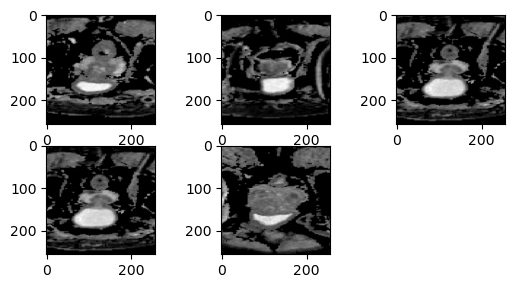

In [27]:
# plot the transformed image array
for i in range(5):
    plt.subplot(3, 3, i + 1)
    #plt.xlabel(dataset[i]["subject_id"]) #need this later?
    plt.imshow(total_dataset[i]["ADC_image"][11,:,:].T, cmap="gray")
plt.show()

In [ ]:
fig = monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(total_dataset[2]["ADC_mask"]), every_n=1, figsize=(3,3))

In [9]:
# function to split image in training loop
from monai.transforms.transform import Transform

class SplitImageCustom(Transform):
    def __init__(self, split_size: int = 3, dim: int = 1, keepdim: bool = True, update_meta=True) -> None:
        self.dim = dim #assume ChannelFirst, and dim=0 is batchsize
        self.keepdim = keepdim
        self.update_meta = update_meta
        self.split_size = split_size
    def __call__(self, img: torch.Tensor) -> list[torch.Tensor]:
        """
        Apply the transform to `img`.
        """
        n_out = img.shape[self.dim] #img.shape[1]= 19 #[1, 19, 256, 256]
        if isinstance(img, torch.Tensor):
            outputs = list(torch.split(img, self.split_size, self.dim)) #6 * [1, 3, 256, 256]
        else:
            outputs = np.split(img, n_out//self.split_size, self.dim)
        # check last item dimension (not checked for np.array yet)
        if outputs[-1].shape[self.dim] != self.split_size:
            outputs = outputs[:-1]
        # put it back to a torch tensor of [batch_size, dim, h, w]: put it outside?
        combined_tensor = torch.cat(outputs, dim=0)
        return combined_tensor

#### Define Model

In [15]:
# "Image Embedding"
model = timm.create_model(
    'mobilevitv2_050.cvnets_in1k',
    pretrained=True,
    features_only=True,
    num_classes=0, #remove classifier
    in_chans = 3 #change number of input channels, cannot use pretrained weights?
)#.to(device) 

'''
# "Feature Map Extraction"
model = timm.create_model(
    'mobilevitv2_050.cvnets_in1k',
    pretrained=True,
    features_only=True,
).to(device)

# "Image Classification"
model = timm.create_model(
    'mobilevitv2_050.cvnets_in1k', 
    pretrained=True
).to(device)
'''

RuntimeError: Hugging Face hub model specified but package not installed. Run `pip install huggingface_hub`.

In [ ]:
# get model specific transforms (normalization, resize)
#data_config = timm.data.resolve_model_data_config(m2)
#transforms = timm.data.create_transform(**data_config, is_training=False)


# torchvision transforms module takes PIL image with 3 channels, need to add lines
pil_image = trans.ToPILImage()(slice_ADC) #(384, 384)
x = transforms(pil_image).unsqueeze(0) #torch.Size([1, 3, 256, 256])
print("x.shape = {}".format(x.shape))
output = m2(x) #list with len=5 tensors

##### Try use wandb?

In [ ]:
import wandb

wandb.login()
wandb.init(project="monai-brain-tumor-segmentation")

config = wandb.config
config.seed = 0
config.roi_size = [224, 224, 144]
config.batch_size = 1
config.num_workers = 4
config.max_train_images_visualized = 20
config.max_val_images_visualized = 20
config.dice_loss_smoothen_numerator = 0
config.dice_loss_smoothen_denominator = 1e-5
config.dice_loss_squared_prediction = True
config.dice_loss_target_onehot = False
config.dice_loss_apply_sigmoid = True
config.initial_learning_rate = 1e-4
config.weight_decay = 1e-5
config.max_train_epochs = 50
config.validation_intervals = 1
config.dataset_dir = "./dataset/"
config.checkpoint_dir = "./checkpoints"
config.inference_roi_size = (128, 128, 64)
config.max_prediction_images_visualized = 20

##### Define loss, optimizer
https://colab.research.google.com/drive/1KD7Kvv2-sNCKvhygcWqJc4Lv1F73sbzQ#scrollTo=hu4Qj5P92ifH 

In [ ]:
# create optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    config.initial_learning_rate,
    weight_decay=config.weight_decay,
)

# create learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config.max_train_epochs
)


In [ ]:
# define loss
#   as multi-label `DiceLoss` using the `monai.losses` API 
#   and the corresponding dice metrics using the `monai.metrics` API.
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

loss_function = DiceLoss(
    smooth_nr=config.dice_loss_smoothen_numerator,
    smooth_dr=config.dice_loss_smoothen_denominator,
    squared_pred=config.dice_loss_squared_prediction,
    to_onehot_y=config.dice_loss_target_onehot,
    sigmoid=config.dice_loss_apply_sigmoid,
)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# use automatic mixed-precision to accelerate training
#scaler = torch.cuda.amp.GradScaler()
#torch.backends.cudnn.benchmark = True

##### Train

In [31]:
#device = torch.device("cuda:0")

model.train()
epoch_loss = 0

batch_data = next(iter(train_loader)) #dictionary object, len=8
inputs, labels = (
    SplitImageCustom(dim = 1)(batch_data["ADC_image"]),#.to(device), #[2, 19, 256, 256] -> [12, 3, 256, 256]
    SplitImageCustom(dim = 1)(batch_data["ADC_mask"]),#.to(device),
)

In [32]:
#with torch.cuda.amp.autocast():
outputs = model(inputs)
    #loss = loss_function(outputs, labels)

In [34]:
for item in outputs:
    print(item.shape)

torch.Size([6, 32, 128, 128])
torch.Size([6, 64, 64, 64])
torch.Size([6, 128, 32, 32])
torch.Size([6, 192, 16, 16])
torch.Size([6, 256, 8, 8])


##### Train (references)

In [ ]:
# official command: 
# check train.py
./distributed_train.sh 4 /data/imagenet 
--model seresnet34 
--sched cosine 
--epochs 150 
--warmup-epochs 5 
--lr 0.4 
--reprob 0.5 
--remode pixel 
--batch-size 256 
--amp -j 4  

In [ ]:
# /timm/ has finetuning tutorial with its own Trainer object
# https://huggingface.co/docs/transformers/main/en/training#finetune-with-trainer 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()


In [ ]:
# https://huggingface.co/docs/transformers/main/en/training#finetune-with-trainer 

from torch.optim import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

In [ ]:
# ref training loop w/ wandb:
#https://colab.research.google.com/drive/1KD7Kvv2-sNCKvhygcWqJc4Lv1F73sbzQ#scrollTo=hu4Qj5P92ifH
# check paper for their training process

In [63]:
# from huggingface transformer git repo:
# https://huggingface.co/docs/transformers/main/en/model_doc/mobilevitv2#transformers.MobileViTV2ForSemanticSegmentation 
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, MobileViTV2ForSemanticSegmentation, MobileViTForSemanticSegmentation, MobileViTFeatureExtractor

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = MobileViTFeatureExtractor.from_pretrained("apple/deeplabv3-mobilevit-xx-small")
model = MobileViTForSemanticSegmentation.from_pretrained("apple/deeplabv3-mobilevit-xx-small")

inputs = feature_extractor(images=image, return_tensors="pt")

outputs = model(**inputs) #SemanticSegmenterOutput(loss, logits, grad_fn, hidden_states, attentions)
logits = outputs.logits #[1, 21, 32, 32]
predicted_mask = logits.argmax(1).squeeze(0) #[32, 32]

/Users/rita/anaconda3/envs/hfenv/lib/python3.12/site-packages/transformers/models/mobilevit/feature_extraction_mobilevit.py:28: FutureWarning: The class MobileViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MobileViTImageProcessor instead.
  warnings.warn(


In [51]:
model.train()

batch_data = next(iter(train_loader)) #dictionary object, len=8
inputs, labels = (
    SplitImageCustom(dim = 1)(batch_data["ADC_image"]),#.to(device), #[2, 19, 256, 256] -> [12, 3, 256, 256]
    SplitImageCustom(dim = 1)(batch_data["ADC_mask"]),#.to(device),
)
outputs = model(inputs)
loss = outputs.loss #23.6 until here
#loss.backward()

In [56]:
logits = outputs.logits #[6,21,16,16]
predicted_mask = logits.argmax(1).squeeze(0) # [6,16,16]
print(logits.shape)
#plt.imshow(predicted_mask)

torch.Size([6, 21, 16, 16])


In [ ]:
plt.imshow()

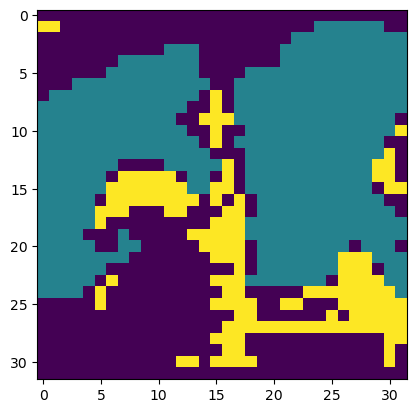

In [47]:
plt.imshow(predicted_mask)

In [12]:
#checking
mobilevitv2_model = timm.create_model(
    'mobilevitv2_050.cvnets_in1k', 
    pretrained=True, 
    features_only=True,
    output_stride=8
)
input_tensor = torch.randn(1, 3, 256, 256)

# Forward pass
output = mobilevitv2_model(input_tensor)
print(output[-1].shape)  #[1, 256, 32, 32]

RuntimeError: Hugging Face hub model specified but package not installed. Run `pip install huggingface_hub`.

In [82]:
# checking
model = DeepLabHead(
    in_channels=516,  # Adjust in_channels if needed
    num_classes=1,  # binary segmentation
    atrous_rates=(6,12,18) #from the paper, default (12,24,36)
)  
input_tensor = torch.randn(1, 516, 516, 516)

# Forward pass
output = model(input_tensor)
print(output.shape) 

KeyboardInterrupt: 

In [75]:
# use DeepLabv3 from torchvision?


# Define the custom backbone class
class MobileViT_Backbone(nn.Module):
    def __init__(self, model):
        super(MobileViT_Backbone, self).__init__()
        self.model = model
        
    def forward(self, x):
        features = self.model(x)
        return features[-4]  # Use the last feature map: [1, 256, 8, 8] -> [1,64,64,64] / [1,128,32,32] or else too small

# Load the MobileViT v2 model without the classification head
mobilevitv2_model = timm.create_model(
    'mobilevitv2_050.cvnets_in1k', 
    pretrained=True, 
    features_only=True
)

# Create the backbone
backbone = MobileViT_Backbone(mobilevitv2_model)

# Define the custom model with DeepLabV3 head
class MobileViT_DeepLabV3(nn.Module):
    def __init__(self, backbone):
        super(MobileViT_DeepLabV3, self).__init__()
        self.backbone = backbone
        self.deeplab_head = DeepLabHead(
            in_channels=64,  # Adjust in_channels if needed
            num_classes=1, 
            atrous_rates=(6,12,18) #from the paper, default (12,24,36)
        )  
        
    def forward(self, x):
        x = self.backbone(x) #last feature map from mobilevitv2: [1, 256, 8, 8] -> [1,128,32,32]
        x = self.deeplab_head(x)
        return x

# Instantiate the model
model = MobileViT_DeepLabV3(backbone)

# Check the model architecture
print(model)

# Sample input tensor
input_tensor = torch.randn(1, 3, 256, 256)

# Forward pass
output = model(input_tensor)
print(output.shape)  # Output should be [1, 1, 256, 256] for binary segmentation


MobileViT_DeepLabV3(
  (backbone): MobileViT_Backbone(
    (model): FeatureListNet(
      (stem): ConvNormAct(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
      )
      (stages_0): Sequential(
        (0): BottleneckBlock(
          (conv1_1x1): ConvNormAct(
            (conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
          )
          (conv2_kxk): ConvNormAct(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn): BatchNormAct2d(
              32, eps=1e-05, moment

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

### Visualize Feature map

In [ ]:
import torchvision.transforms as trans
# Feature map
m2 = timm.create_model(
    'mobilevitv2_050.cvnets_in1k', 
    features_only=True, 
    pretrained=True) 

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(m2)
transforms = timm.data.create_transform(**data_config, is_training=False)

m2 = m2.eval()

# torchvision transforms module takes PIL image with 3 channels, need to add lines
pil_image = trans.ToPILImage()(slice_ADC)
x = transforms(pil_image).unsqueeze(0) #torch.Size([1, 3, 256, 256])
print("x.shape = {}".format(x.shape))
output = m2(x) #list with len=5 tensors

#for o in output:
    # print shape of each feature map in output
    # e.g.:
    #  torch.Size([1, 32, 128, 128])
    #  torch.Size([1, 64, 64, 64])
    #  torch.Size([1, 128, 32, 32])
    #  torch.Size([1, 192, 16, 16])
    #  torch.Size([1, 256, 8, 8])

    #print(o.shape)
#m2.feature_info.channels() #[32, 64, 128, 192, 256]


In [ ]:
# draft
print(data_config)

In [ ]:
# visualize feature map
fms = []

for feature_map in output:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0] #feature_map.shape[0] = 32,64,128,192,256
    fm = gray_scale.data.cpu().numpy()
    fms.append(fm)

    print(fm.shape)
    # the feature map become smaller and contain more information, "folding"???
    #(128, 128)
    #(64, 64)
    #(32, 32)
    #(16, 16)
    #(8, 8)

In [ ]:
fig = plt.figure(figsize=(30, 50))
fig.add_subplot(6, 3, 1)
ori = plt.imshow(x.squeeze(0)[1,:,:], cmap='Greys_r'); plt.title("transforms(ADC)", fontsize=30)

for i in range(len(fms)):
    a = fig.add_subplot(6, 3, i+2)
    imgplot = plt.imshow(fms[i])
    a.axis("off")
    a.set_title("Layer {} from last {}".format(len(fms)-i, fms[i].shape), fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')
cbar = plt.colorbar()

In [ ]:
# temp output for T2
fig = plt.figure(figsize=(30, 50))
fig.add_subplot(6, 3, 1)
ori = plt.imshow(x.squeeze(0)[1,:,:], cmap='Greys_r'); plt.title("transforms(T2)", fontsize=30)

for i in range(len(fms)):
    a = fig.add_subplot(6, 3, i+2)
    imgplot = plt.imshow(fms[i])
    a.axis("off")
    a.set_title("Layer {} from last {}".format(len(fms)-i, fms[i].shape), fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')
cbar = plt.colorbar()

In [ ]:
# try a different model v1
import torchvision.transforms as trans

m1 = timm.create_model(
    'mobilevit_xxs.cvnets_in1k', 
    features_only=True, 
    pretrained=True)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(m1)
transforms = timm.data.create_transform(**data_config, is_training=False)

# torchvision transforms module takes PIL image with 3 channels, need to add lines
pil_image = trans.ToPILImage()(slice_T2)
x = transforms(pil_image).unsqueeze(0) #torch.Size([1, 3, 256, 256])
print("x.shape = {}".format(x.shape))
output = m1(x) #list with len=5 tensors

for o in output:
    # print shape of each feature map in output
    # e.g.:
    #  torch.Size([1, 16, 128, 128])
    #  torch.Size([1, 24, 64, 64])
    #  torch.Size([1, 48, 32, 32])
    #  torch.Size([1, 64, 16, 16])
    #  torch.Size([1, 320, 8, 8])

    print(o.shape)

In [ ]:
# temp output for T2 in m1
fig = plt.figure(figsize=(30, 50))
fig.add_subplot(6, 3, 1)
ori = plt.imshow(x.squeeze(0)[1,:,:], cmap='Greys_r'); plt.title("transforms(T2)", fontsize=30)

for i in range(len(fms)):
    a = fig.add_subplot(6, 3, i+2)
    imgplot = plt.imshow(fms[i])
    a.axis("off")
    a.set_title("Layer {} from last {}".format(len(fms)-i, fms[i].shape), fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')
cbar = plt.colorbar()

### Example Codes from HF
https://huggingface.co/timm/mobilevitv2_050.cvnets_in1k 

##### Image Classification

In [ ]:
# Example code from HF (Image Classification)
from urllib.request import urlopen
from PIL import Image
#import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model('mobilevitv2_050.cvnets_in1k', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

x = transforms(img).unsqueeze(0)
output = model(x)  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)


In [ ]:
plt.imshow(img)
print(x.shape) #[1, 3, 256, 256]
#print(output)             #shape: [1, 1000]
#print(top5_class_indices) #[969, 967, 928, 960, 927]   shape: [1, 5]
#print(top5_probabilities) #[24.9318, 12.4587,  8.9054,  6.5909,  5.6044]  shape:[1, 5]

##### Feature Map Extraction

In [ ]:
# Example code from HF (Feature Map Extraction)
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model(
    'mobilevitv2_050.cvnets_in1k',
    pretrained=True,
    features_only=True,
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

for o in output:
    # print shape of each feature map in output
    # e.g.:
    #  torch.Size([1, 32, 128, 128])
    #  torch.Size([1, 64, 64, 64])
    #  torch.Size([1, 128, 32, 32])
    #  torch.Size([1, 192, 16, 16])
    #  torch.Size([1, 256, 8, 8])

    print(o.shape)


In [ ]:
# visualize feature map
processed = []

for feature_map in output:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    fm = gray_scale.data.cpu().numpy()
    processed.append(fm)

    print(fm.shape)
    #(128, 128)
    #(64, 64)
    #(32, 32)
    #(16, 16)
    #(8, 8)

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 3, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title("Layer {} from last {}".format(len(processed)-i, processed[i].shape), fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')
cbar = plt.colorbar()

In [ ]:
# try different model v1
# Example code from HF (Feature Map Extraction)
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model(
    'mobilevit_xxs.cvnets_in1k',
    pretrained=True,
    features_only=True,
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

for o in output:
    # print shape of each feature map in output
    # e.g.:
    #  torch.Size([1, 16, 128, 128])
    #  torch.Size([1, 24, 64, 64])
    #  torch.Size([1, 48, 32, 32])
    #  torch.Size([1, 64, 16, 16])
    #  torch.Size([1, 320, 8, 8])

    # difference in dim[1]: 32,64,128,192,256 -> 16,24,48,64,320

    print(o.shape)


In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 3, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title("Layer {} from last {}".format(len(processed)-i, processed[i].shape), fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')
cbar = plt.colorbar()

##### Image Embedding

In [ ]:
# Example code from HF (Image Embedding)
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model(
    'mobilevitv2_050.cvnets_in1k',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear, but still have global pooling?
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # output is (batch_size, num_features) = [1, 256] tensor

# or equivalently (without needing to set num_classes=0)
#output = model.forward_features(transforms(img).unsqueeze(0)) #(1, 256, 8, 8) tensor
#output = model.forward_head(output, pre_logits=True) #(1, num_features) tensor

plt.imshow(img)
print(output)